In [23]:
import pandas as pd

# CSV 파일 불러오기 (euc-kr 인코딩 사용)
book_info = pd.read_csv('통합_정보_합침.csv', encoding='euc-kr')
loan_info = pd.read_csv('대출정보.csv', encoding='euc-kr')

# 1. 컬럼 이름의 공백 제거
book_info.columns = book_info.columns.str.strip()
loan_info.columns = loan_info.columns.str.strip()

# 2. 출판년도를 숫자형으로 변환
book_info['출판년도'] = pd.to_numeric(book_info['출판년도'], errors='coerce')

# 3. 대출일시를 datetime으로 변환하고 대출 연도 생성
loan_info['대출일시'] = pd.to_datetime(loan_info['대출일시'])
loan_info['대출연도'] = loan_info['대출일시'].dt.year

# 4. 도서ID를 기준으로 대출정보와 도서 정보를 연결
loan_info = loan_info.merge(book_info[['도서ID', '서명', '출판년도']], on='도서ID')

# 5. 출판년도가 다른 도서명을 그룹핑하여 가장 빠른/늦은 출판년도 확인
book_group = book_info.groupby('서명').agg(
    earliest_year=('출판년도', 'min'),
    latest_year=('출판년도', 'max'),
    book_count=('출판년도', 'count')
).reset_index()

# 6. 출판년도가 다른 (2권 이상) 도서만 필터링
multiple_editions = book_group[book_group['book_count'] > 1]

# 7. 벡터화 조건으로 가장 빠른 연도와 가장 늦은 연도의 도서 필터링
earliest_books = book_info[book_info['서명'].isin(multiple_editions['서명']) & (book_info['출판년도'] == book_info['서명'].map(book_group.set_index('서명')['earliest_year']))]
latest_books = book_info[book_info['서명'].isin(multiple_editions['서명']) & (book_info['출판년도'] == book_info['서명'].map(book_group.set_index('서명')['latest_year']))]

# 8. 가장 늦은 출판년도 이후의 대출 기록만 선택
relevant_loans = loan_info[loan_info['대출연도'] > loan_info['출판년도']]

# 9. 가장 빠른 연도 및 가장 늦은 연도의 도서 대출 수 집계
earliest_loans = relevant_loans[relevant_loans['도서ID'].isin(earliest_books['도서ID'])].groupby('서명').size().reset_index(name='earliest_loans')
latest_loans = relevant_loans[relevant_loans['도서ID'].isin(latest_books['도서ID'])].groupby('서명').size().reset_index(name='latest_loans')

# 10. 대출 수 차이 계산
final_result = multiple_editions[['서명', 'earliest_year', 'latest_year']].merge(
    earliest_loans, on='서명', how='left'
).merge(
    latest_loans, on='서명', how='left'
)

# NaN 값(대출이 없는 경우)을 0으로 처리하고 대출 수 차이 계산
final_result['earliest_loans'].fillna(0, inplace=True)
final_result['latest_loans'].fillna(0, inplace=True)
final_result['대출 수 차이'] = final_result['latest_loans'] - final_result['earliest_loans']

# 11. 결과 CSV로 저장
final_result[['서명', 'earliest_year', 'latest_year', 'earliest_loans', 'latest_loans', '대출 수 차이']].to_csv(
    '대출차이분석.csv', index=False, encoding='euc-kr'
)

print("분석 결과가 '대출차이분석.csv'로 저장되었습니다.")


분석 결과가 '대출차이분석.csv'로 저장되었습니다.


C:\Users\songbh0304\AppData\Local\Temp\ipykernel_29408\3458779612.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_result['earliest_loans'].fillna(0, inplace=True)
C:\Users\songbh0304\AppData\Local\Temp\ipykernel_29408\3458779612.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

C:\Users\songbh0304\AppData\Local\Temp\ipykernel_29408\3184320683.py:21: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\songbh0304\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


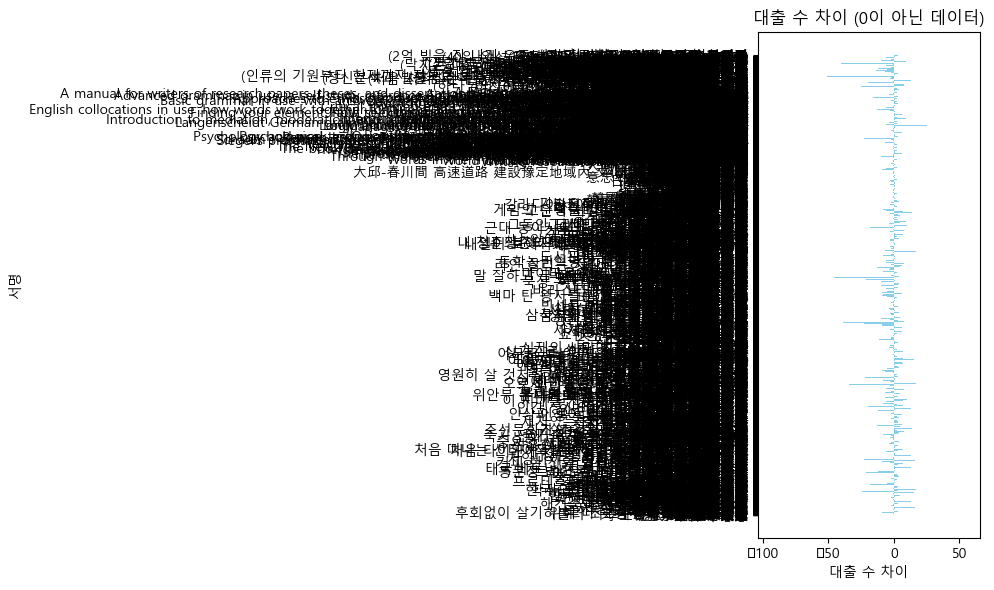

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 결과 CSV 불러오기
final_result = pd.read_csv('대출차이분석.csv', encoding='euc-kr')

# 대출 수 차이가 0이 아닌 데이터만 필터링
filtered_result = final_result[final_result['대출 수 차이'] != 0]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.barh(filtered_result['서명'], filtered_result['대출 수 차이'], color='skyblue')
plt.xlabel('대출 수 차이')
plt.ylabel('서명')
plt.title('대출 수 차이 (0이 아닌 데이터)')
plt.gca().invert_yaxis()  # 서명이 위에서부터 나열되도록 설정
plt.tight_layout()
plt.show()



양수(+) 대출 수 차이:
 - 개수: 1805
 - 총합: 7024.0

음수(-) 대출 수 차이:
 - 개수: 1527
 - 총합: -9704.0


C:\Users\songbh0304\AppData\Local\Temp\ipykernel_29408\2296100759.py:21: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()


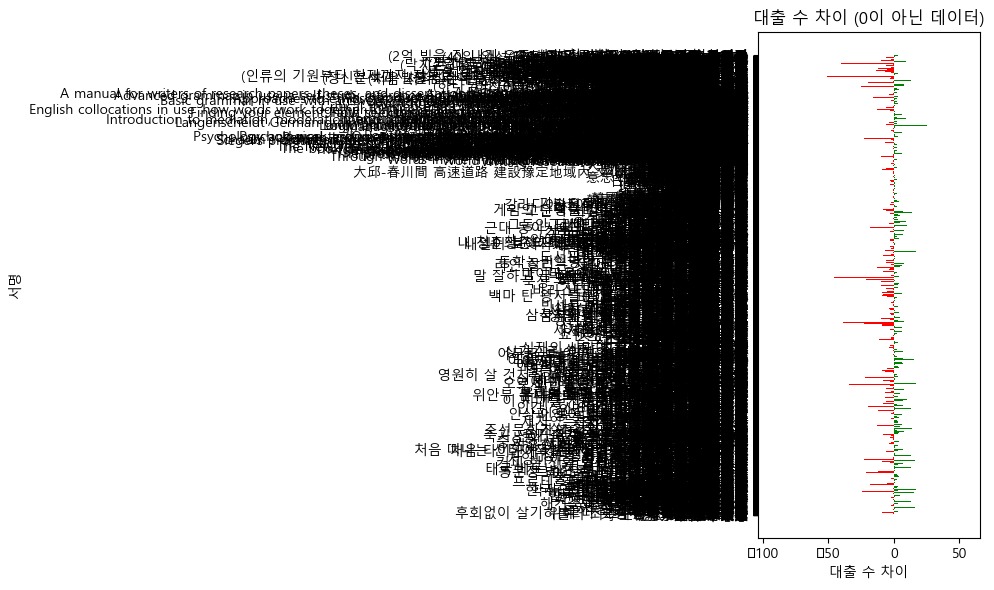

In [26]:
positive_diffs = filtered_result[filtered_result['대출 수 차이'] > 0]
negative_diffs = filtered_result[filtered_result['대출 수 차이'] < 0]

# 결과 출력
print("양수(+) 대출 수 차이:")
print(f" - 개수: {len(positive_diffs)}")
print(f" - 총합: {positive_diffs['대출 수 차이'].sum()}")

print("\n음수(-) 대출 수 차이:")
print(f" - 개수: {len(negative_diffs)}")
print(f" - 총합: {negative_diffs['대출 수 차이'].sum()}")

# 그래프 재그리기
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(filtered_result['서명'], filtered_result['대출 수 차이'], color=filtered_result['대출 수 차이'].apply(lambda x: 'green' if x > 0 else 'red'))
plt.xlabel('대출 수 차이')
plt.ylabel('서명')
plt.title('대출 수 차이 (0이 아닌 데이터)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()